# Step 0: Install Ultralytics

`!pip install ultralytics`

# Step 1: Import Packages and Functions

In [1]:
from ultralytics.data.annotator import auto_annotate
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
import shutil as su, cv2, glob, os
import pathlib

# Step 2: Annotation Setup

1. Place all images to be annotated in a single directory.
2. Run the auto_annotate function on that directory as shown below. It will automatically download a set of YOLO and SAM weights into the directory where your script or notebook runs from, if you don't already have them in there. Make sure to specify your output directory as an argument to make it easier to keep track of your outputs.

Here's what my directory structure looks like after running everything as is.

Directories are followed by a /, and all files inside the directory are indented right under it:

(Working Directory)/
- This notebook
- yolov8x.pt
- sam_l.pt
- autoannot.py (more on this in a bit)
- <b><u>Auto-Annotation Demo/</u></b>
    - Images to be annnotated
    - Annotations/
        - Annotation output from SAM
        - YOLO/
            - YOLO-formatted annotations
            
Just place the images in any directory (your copy of this notebook and the model weights can be in there too, as long as you adjust the arguments to all the functions below accordingly) and this notebook will automatically add in all the other subdirectories and everything that goes in them.

In [2]:
imdir = 'Auto-Annotation Demo/' # make sure this points to where your images are
    # RELATIVE TO WHERE THIS NOTEBOOK IS.
    # And make sure there's a double backslash (\\) at the end of the string.
outdir = f'{imdir}Annotations/' # can be anything, really. I suggest pointing to someplace
    # inside imdir because it's just nicely organised that way.
    # Once again, make sure there's a double backslash (\\) at the end of the string.
try:
    os.mkdir(outdir) # spares you the trouble of creating outdir yourself.
except:
    ;
auto_annotate(imdir,
              'yolov8x.pt',
              'sam_l.pt',
              output_dir=outdir) # where the magic begins.


image 1/20 E:\OneDrive - UBC\AgroBot\Datasets\Auto-Annotation Demo\Image(211).jpg: 640x640 1 banana, 34.0ms
image 2/20 E:\OneDrive - UBC\AgroBot\Datasets\Auto-Annotation Demo\Image(212).jpg: 640x640 1 banana, 53.0ms
image 3/20 E:\OneDrive - UBC\AgroBot\Datasets\Auto-Annotation Demo\Image(213).jpg: 640x640 2 bananas, 48.0ms
image 4/20 E:\OneDrive - UBC\AgroBot\Datasets\Auto-Annotation Demo\Image(214).jpg: 640x640 1 banana, 40.0ms
image 5/20 E:\OneDrive - UBC\AgroBot\Datasets\Auto-Annotation Demo\Image(215).jpg: 640x640 1 banana, 1 apple, 49.0ms
image 6/20 E:\OneDrive - UBC\AgroBot\Datasets\Auto-Annotation Demo\Image(216).jpg: 640x640 1 banana, 1 apple, 44.0ms
image 7/20 E:\OneDrive - UBC\AgroBot\Datasets\Auto-Annotation Demo\Image(217).jpg: 640x640 1 banana, 36.6ms
image 8/20 E:\OneDrive - UBC\AgroBot\Datasets\Auto-Annotation Demo\Image(218).jpg: 640x640 2 bananas, 45.0ms
image 9/20 E:\OneDrive - UBC\AgroBot\Datasets\Auto-Annotation Demo\Image(219).jpg: 640x640 1 banana, 44.0ms
image 1

Currently, the .txt files in the output directory should just contain an integer followed by a list of floats between 0 and 1. They'll have multiple lines if multiple objects were detected, and you can know when this is the case by checking the output of your auto-annotation. For instance, you can see above that some images have "2 bananas" or "1 banana, 1 apple" written next to them.

Each line in the files is actually an arbitrary class label for the object detected (the integer) followed by a list of points that form a polygon acting as the mask of each object detected (a list of floats with a length divisible by 2); to use these with your own YOLO model, they need to be converted into YOLO's annotation format:

# Step 3: Conversion to YOLO Format

In [3]:
def to_yolo(path):
    '''
    Converts SAM's annotation output to YOLO format. If called as is, this function
        will create a new folder called "YOLO" in the same directory as the SAM annotations
        (if it doesn't already exist) and copy all the YOLO-formatted annotations into it.
        See lines 30 onward of the cell containing this function's definition for details on how
        to alter this behaviour.
    '''
    
    path = path.replace("\\","/")
    
    try:
        labels = pd.read_table(path, sep='|', header=None) # Reads in annotations as a 1-by-n DataFrame
        # where each detected object (i.e. row in the .txt file) appears as one long string on a
        # separate row.
    except:
        print(f'\"{path}\" is empty or does not exist.')
        return None
    
    labels = [(np.array(labels[0][i].split(' ')
                       ).astype(np.double)[1:]
              ).reshape(-1,2)
             for i in range(labels.shape[0])] # Uses string operations to turn the DataFrame into
                # a list of numpy arrays where each array corresponds to a detected object 
                # (i.e. row in the .txt file). Each array is reshaped to n-by-2 as the floats appear
                # in (x, y) pairs in the .txt file.
    labels = np.array([[i.min(0), i.max(0)] for i in labels]) # Extracts the minimum and maximum x
                # and y values in each numpy array and turns the previous list into a list of these
                # mins and maxes
    
    # Finds the centre of each bounding box, as well as the width and height of the box.
    pcs = np.array([[i.mean(0)] for i in labels]).reshape(-1,2)
    ws = np.array([[i[1,0]-i[0,0]] for i in labels]).reshape(-1)
    hs = np.array([[i[1,1]-i[0,1]] for i in labels]).reshape(-1)
    
    # Writes the values found above as a line in a new .txt file. If the original annotation
    # had multiple objects, a separate line is written in for each object.
    out = path.split("/")[-1] # String operation on the supplied path to extract the file name.
    rootdir = path.split(out)[0] # String operation on the supplied path to extract the directory
        # the image resides in.
        
    try:
        os.mkdir(f'{rootdir}YOLO') # Creates the YOLO subfolder if it doesn't already exist.
    except:
        ;
    with open(f'{rootdir}YOLO/{out}', 'w') as f: 
        '''CHANGE LINES 34 AND 37 if you want to use a
        different structure with your directories. Of course, you can add functionality to
        be able to specify any output directory if you feel like that's more useful.'''
        for i in range(len(pcs)): # Ensures every object gets a line in the YOLO-formatted .txt
            f.write(f'0 {pcs[i][0]} {pcs[i][1]} {ws[i]} {hs[i]}\n') # Prints "0" as an arbitrary
                # class label, followed by the YOLO-formatted bounding box.

In [4]:
# to_yolo is designed to run on a single file, so I just used glob to loop over all of them.
for i in glob.glob("Auto-Annotation Demo/Annotations/*.txt"):
    to_yolo(i)

In [5]:
annots = glob.glob(f'{outdir}YOLO/*.txt')
if "\\" in annots[0]:
    for i in range(len(annots)):
        annots[i] = annots[i].replace("\\","/")

for i in glob.glob(f'{imdir}*.jpg'):
    path = i.replace("\\","/")
    imname = path.split("/")[-1][:-4]
    if not (f'{outdir}YOLO/{imname}.txt'
            in annots):
        with open(f'{outdir}YOLO/{imname}.txt', 'w') as f:
            f.write('')
        with open(f'{outdir}{imname}.txt', 'w') as f:
            f.write('')

In [6]:
def arr(box):
    '''
    Helper function for display_boxes.
    '''
    return list(box.reshape(-1))

def display_boxes(path, annot_path=None, annot_suffix=False):
    '''
    Displays the bounding boxes for an image.
    
    path: the path to the image, relative to the directory from which display_boxes is called.
    annot_path: the path to the annotations. This is relative to the same directory as path if
        annot_suffix is False, or relative to path itself if annot_suffix is True
    annot_suffix: pass True here to spare yourself the trouble of writing the same file path twice
        when your annotations are in a subdirectory of the image's location.
    '''
    import numpy as np, PIL as img
    
    path = path.replace("\\", "/")    
    imname = path.split("/")[-1]
    
    if annot_suffix: # If the annotations are in a subdirectory of the directory with the images,
            # you can pass True to this argument and specify annot_path relative to the image's
            # directory
        annot_path=f'{path.split(imname)[0]}{annot_path}/{imname[:-4]}'
        
    if not annot_path: # Assumes annotations are in the same directory as the image if a path
            # to them is not supplied
        annot_path = f'{path[:-3]}txt'
        
    try:
        bbarr = np.loadtxt(f'{annot_path}.txt')[:,1:] # Loads all bounding boxes after removing
            # the class labels
    except:
        raise NameError("No .txt annotations found for this image.")
    
    try:
        testimg = img.Image.open(path)
    except:
        raise NameError("Image not found.")
    
    # Converts the bounding box into points that Pillow can use to draw the boxes
    (xc, yc, w, h) = (bbarr[:,i] for i in range(4))
    bbarr[:,0] = xc-w/2.
    bbarr[:,1] = yc-h/2.
    bbarr[:,2] = xc+w
    bbarr[:,3] = yc+h
    bbarr = bbarr.reshape(-1, 2, 2)
    
    # Some matrix multiplication to un-normalise all the coordinates.
    # Should work on all aspect ratios.
    bbarr = np.matmul(bbarr, np.array([[testimg.width, 0],
                                       [0, testimg.height]])
                     ).astype(int)
    
    draw = img.ImageDraw.Draw(testimg)
    
    for i in bbarr:
        try:
            draw.rectangle(arr(i), outline='#ff0000', width=4)
        except:  
            print(arr(i))
        
    return testimg

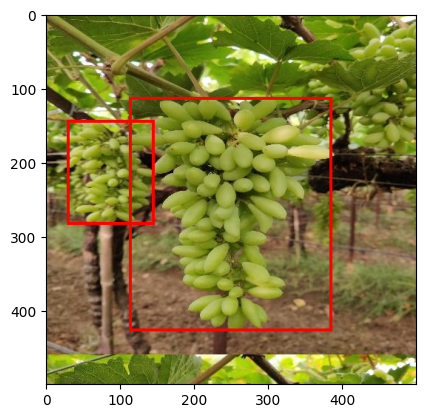

In [7]:
# Example of how to verify your bounding boxes calculated correctly.
cvim = display_boxes("Auto-Annotation Demo/Image(213).jpg",
                     "Annotations/YOLO", True)
plt.imshow(cvim)